# Analysis of Airbnb data

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re

from geopy.distance import great_circle
from collections import Counter
from itertools import chain

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from tqdm import tqdm

## Dataset

In [23]:
data = pd.read_csv('assets/listings.csv')

data.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,17878,https://www.airbnb.com/rooms/17878,20211224070558,2021-12-25,"Very Nice 2Br in Copacabana w. balcony, fast WiFi",Discounts for long term stays. <br />- Large b...,This is the one of the bests spots in Rio. Bec...,https://a0.muscache.com/pictures/65320518/3069...,68997,https://www.airbnb.com/users/show/68997,...,4.90,4.76,4.66,NaN,f,1,1,0,0,1.92
1,24480,https://www.airbnb.com/rooms/24480,20211224070558,2021-12-25,"Nice and cozy near Ipanema Beach, w/ home office","My studio is located in the best of Ipanema, t...","The beach, the lagoon, Ipanema is a great loca...",https://a0.muscache.com/pictures/11955612/b28e...,99249,https://www.airbnb.com/users/show/99249,...,4.90,4.97,4.58,NaN,f,1,1,0,0,0.62
2,25026,https://www.airbnb.com/rooms/25026,20211224070558,2021-12-25,Beautiful Modern Decorated Studio in Copa,"Our apartment is a little gem, everyone loves ...",Copacabana is a lively neighborhood and the ap...,https://a0.muscache.com/pictures/3003965/68ebb...,102840,https://www.airbnb.com/users/show/102840,...,4.90,4.81,4.56,NaN,f,1,1,0,0,1.69
3,35636,https://www.airbnb.com/rooms/35636,20211224070558,2021-12-26,Cosy flat close to Ipanema beach,This cosy apartment is just a few steps away ...,The apartment street is very quiet and safe ....,https://a0.muscache.com/pictures/20009355/38b6...,153232,https://www.airbnb.com/users/show/153232,...,4.88,4.90,4.65,NaN,f,1,1,0,0,1.82
4,35764,https://www.airbnb.com/rooms/35764,20211224070558,2021-12-25,COPACABANA SEA BREEZE - RIO - 20 X Superhost,Our newly renovated studio is located in the b...,Our guests will experience living with a local...,https://a0.muscache.com/pictures/23782972/1d3e...,153691,https://www.airbnb.com/users/show/153691,...,4.94,4.94,4.87,NaN,f,1,1,0,0,2.76


In [24]:
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [25]:
# Selecionando columas de interesse
columns_of_interest = [
    'id', 'description', 'host_has_profile_pic', 
    'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',   
    'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
    'instant_bookable', 'number_of_reviews'
]

data = data[columns_of_interest]

In [26]:
data['price'] = data.apply(lambda row: float(re.sub('[$,]', '', row.price)), axis=1)

data['host_has_profile_pic'] = data['host_has_profile_pic'].map({'t': 1, 'f': 0})
data['instant_bookable'] = data['instant_bookable'].map({'t': 1, 'f': 0})


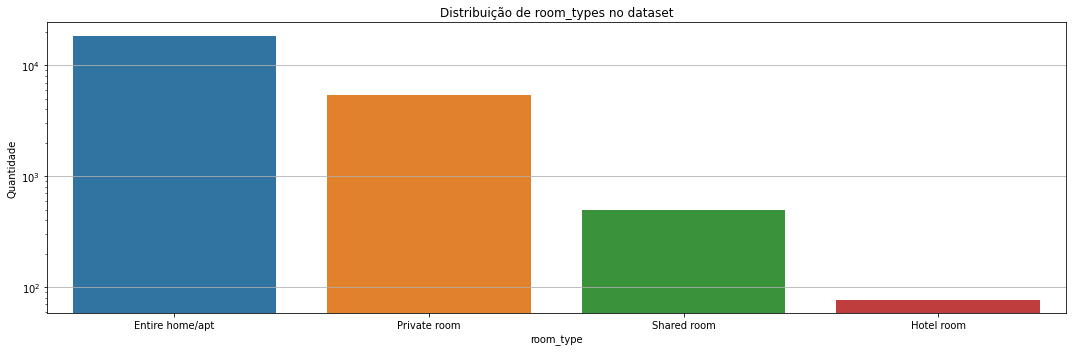

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.countplot(
    data=data,
    x='room_type',
    ax=ax
)

ax.set_yscale('log')
ax.yaxis.grid()
ax.set(
    title='Distribuição de room_types no dataset',
    xlabel='room_type',
    ylabel='Quantidade'
)

plt.tight_layout()
plt.show()

In [28]:
data.property_type.value_counts(normalize=True)

Entire rental unit                  0.576602
Private room in rental unit         0.131777
Entire condominium (condo)          0.063628
Entire residential home             0.045256
Private room in residential home    0.040816
                                      ...   
Houseboat                           0.000041
Entire bed and breakfast            0.000041
Treehouse                           0.000041
Private room in treehouse           0.000041
Cave                                0.000041
Name: property_type, Length: 82, dtype: float64

In [29]:
data.price.describe()

count     24549.000000
mean       1029.592285
std        5403.742297
min           0.000000
25%         250.000000
50%         479.000000
75%         900.000000
max      650476.000000
Name: price, dtype: float64

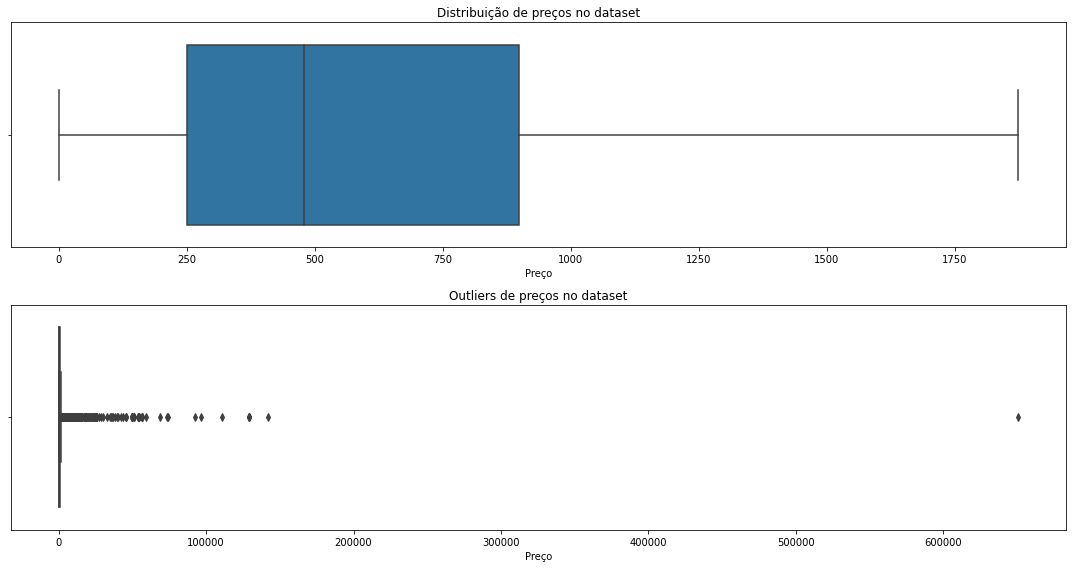

In [30]:
fig, axes = plt.subplots(nrows=2, figsize=(15, 8))

sns.boxplot(
    data=data,
    x='price',
    showfliers=False,
    ax=axes[0]
)

axes[0].set(
    title='Distribuição de preços no dataset',
    xlabel='Preço'
)

sns.boxplot(
    data=data,
    x='price',
    ax=axes[1]
)

axes[1].set(
    title='Outliers de preços no dataset',
    xlabel='Preço'
)

plt.tight_layout()
plt.savefig('assets/price_distribuition.jpg', dpi=300)
plt.show()

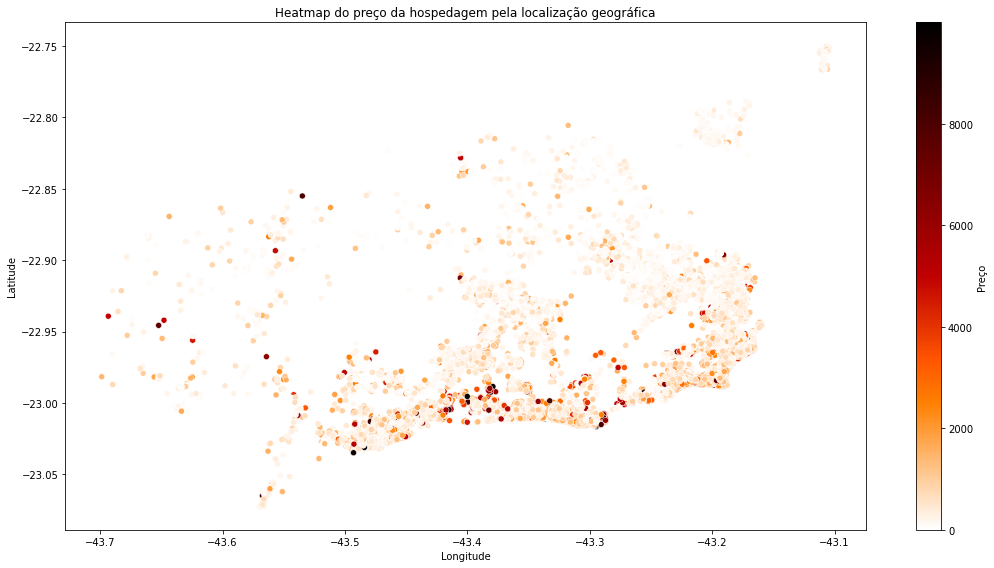

In [31]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.scatterplot(
    data=data[data.price < 10000],
    x='longitude', 
    y='latitude',
    hue='price',
    palette='gist_heat_r',
    ax=ax
)

norm = plt.Normalize(
    data[data.price < 10000]['price'].min(), 
    data[data.price < 10000]['price'].max()
)
sm = plt.cm.ScalarMappable(cmap="gist_heat_r", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm).ax.set_ylabel('Preço')

ax.set(
    title='Heatmap do preço da hospedagem pela localização geográfica',
    xlabel='Longitude',
    ylabel='Latitude'
)

plt.tight_layout()
plt.savefig('assets/price_per_loc.jpg', dpi=300)
plt.show()

In [32]:
data

,id,description,host_has_profile_pic,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,instant_bookable,number_of_reviews
0,17878,Discounts for long term stays. <br />- Large b...,1.0,-22.965990,-43.179400,Entire condominium (condo),Entire home/apt,5,2.0,2.0,"[""Bed linens"", ""Stove"", ""Elevator"", ""Cable TV""...",350.0,5,0,267
1,24480,"My studio is located in the best of Ipanema, t...",1.0,-22.984050,-43.201890,Entire rental unit,Entire home/apt,2,1.0,1.0,"[""Extra pillows and blankets"", ""Dining table"",...",296.0,3,0,85
2,25026,"Our apartment is a little gem, everyone loves ...",1.0,-22.977350,-43.191050,Entire rental unit,Entire home/apt,3,1.0,1.0,"[""Free street parking"", ""Dining table"", ""Bed l...",387.0,3,0,238
3,35636,This cosy apartment is just a few steps away ...,1.0,-22.988390,-43.192320,Entire rental unit,Entire home/apt,2,1.0,1.0,"[""Washer"", ""Cleaning before checkout"", ""Free s...",172.0,2,0,181
4,35764,Our newly renovated studio is located in the b...,1.0,-22.981070,-43.191360,Entire loft,Entire home/apt,2,1.0,1.0,"[""Beachfront"", ""Extra pillows and blankets"", ""...",260.0,3,0,378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24544,53957052,Sejam Bem Vindos ao Copacabana Family Home! Ap...,1.0,-22.977974,-43.190044,Entire rental unit,Entire home/apt,10,4.0,8.0,"[""Dishes and silverware"", ""Security cameras on...",1786.0,4,1,0
24545,53957980,The apartment was completely renovated at the ...,1.0,-22.932098,-43.177090,Entire rental unit,Entire home/apt,4,1.0,2.0,"[""Paid parking lot off premises"", ""Pour-over c...",460.0,2,1,1
24546,53958210,Leve toda a família a este ótimo lugar com mui...,1.0,-22.962902,-43.170973,Entire rental unit,Entire home/apt,8,3.0,4.0,"[""Hair dryer"", ""Iron"", ""Dishes and silverware""...",891.0,2,1,0
24547,53958814,Curta uma experiência elegante neste lugar bem...,1.0,-22.968714,-43.183293,Entire rental unit,Entire home/apt,6,1.0,8.0,"[""Paid parking lot off premises"", ""Extra pillo...",177.0,4,0,0


In [33]:
data.isna().sum()

id                         0
description             1213
host_has_profile_pic      15
latitude                   0
longitude                  0
property_type              0
room_type                  0
accommodates               0
bedrooms                1490
beds                     347
amenities                  0
price                      0
minimum_nights             0
instant_bookable           0
number_of_reviews          0
dtype: int64

In [34]:
# Remove linhas sem informações de bedrooms
data.dropna(subset=['bedrooms'], inplace=True)

# Preenche linha faltantes em beds com a quantidade de bedrooms
data.beds.fillna(value=data.bedrooms, inplace=True)

# Preenche linha faltantes em host_has_profile_pic com falso
data.host_has_profile_pic.fillna(value=0, inplace=True)

# Preenche linha faltantes em description com string vazia
data.description.fillna(value='', inplace=True)

In [35]:
data.isna().sum()

id                      0
description             0
host_has_profile_pic    0
latitude                0
longitude               0
property_type           0
room_type               0
accommodates            0
bedrooms                0
beds                    0
amenities               0
price                   0
minimum_nights          0
instant_bookable        0
number_of_reviews       0
dtype: int64

##  Feature Engineering

### Distância para o centro da cidade

In [36]:
def distance_to_center(lat: float, lon: float) -> float:
    """
        Retorna a distância de um ponto para o centro do rio de janeiro em km.    

    Args:
        lat (float): Latitude do ponto.
        lon (float): Longitude do ponto.

    Returns:
        float: Distância de um ponto para o centro do rio de janeiro em km.
    """
    
    rio_center = (-22.907, -43.1819)
    accommodation = (lat, lon)

    return great_circle(rio_center, accommodation).km

data['distance_center'] = data.apply(
    lambda row: distance_to_center(row.latitude, row.longitude),
    axis=1
)

### Comodidades da hospedagem 

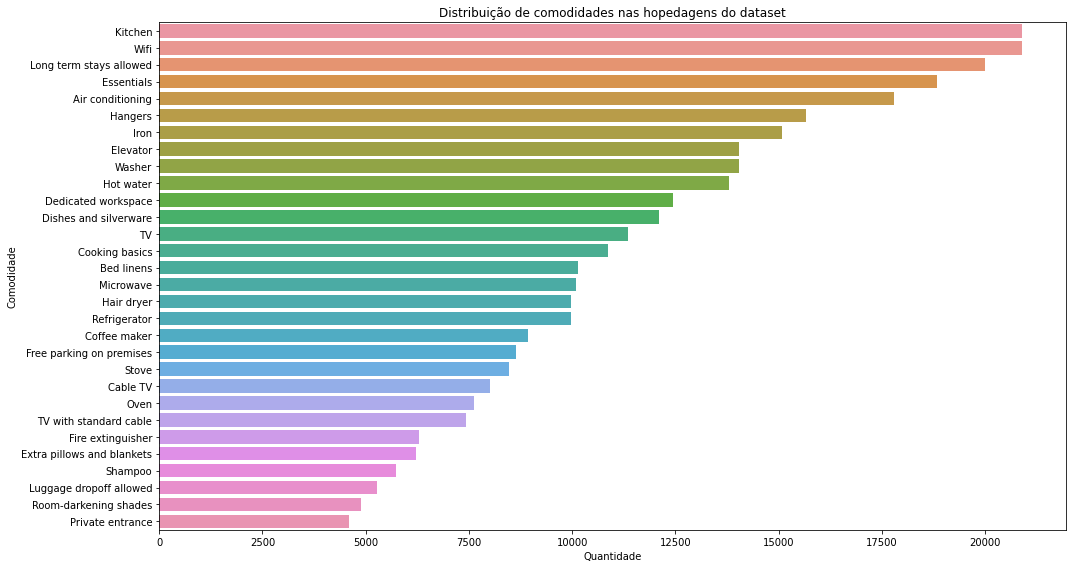

In [37]:
amenities_counter = Counter(list(
    chain.from_iterable(data.apply(lambda row: eval(row.amenities), axis=1))
))

fig, ax = plt.subplots(figsize=(15, 8))

sns.barplot(
    data=pd.DataFrame(
        amenities_counter.most_common(30), 
        columns=['Comodidade', 'Quantidade']
    ),
    x='Quantidade',
    y='Comodidade',
    ax=ax
)

ax.set(
    title='Distribuição de comodidades nas hopedagens do dataset',
)

plt.tight_layout()
plt.show()

In [38]:
for amenitie, _ in amenities_counter.most_common(30):
    data[amenitie] = data.apply(lambda row: 1 if amenitie in eval(row.amenities) else 0, axis=1)

## Model

In [39]:
features = data.drop(columns=['id', 'description', 'latitude', 'longitude', 'amenities', 'price'])
property_type_ecoder = LabelEncoder()
room_type_encoder = LabelEncoder()

features['property_type'] = property_type_ecoder.fit_transform(features.property_type)
features['room_type'] = room_type_encoder.fit_transform(features.room_type)

features = StandardScaler().fit_transform(features)

target = data['price']

In [40]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123)

In [47]:
classifiers = [
    # ('Logistic', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestRegressor(n_jobs=-1)),
    ('KNN', KNeighborsRegressor()),
    ('XGB', XGBRegressor())
]

pbar = tqdm(classifiers)
for name, clf in pbar:
    pbar.set_description(f'Fitting {name} Regressor: ')
    clf.fit(x_train, y_train)
print('\nAll classifers ready!')


Fitting XGB Regressor: : 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]          


All classifers ready!


In [48]:
def get_scores(clf_name, clf):
    y_pred = clf.predict(x_test)

    return (
        clf_name, 
        r2_score(y_test, y_pred), 
        np.sqrt(mean_squared_error(y_test, y_pred)), 
        mean_absolute_error(y_test, y_pred) 
    )

predictions_scores = [ get_scores(clf_name, clf) for clf_name, clf in classifiers ]

In [49]:
pd.DataFrame(predictions_scores, columns=['Model', 'R2 Score', 'RMSE', 'MAE'])

,Model,R2 Score,RMSE,MAE
0,Random Forest,-0.055514,3970.023906,879.603356
1,KNN,0.038439,3789.216544,816.915568
2,XGB,-0.051621,3962.695788,876.995758


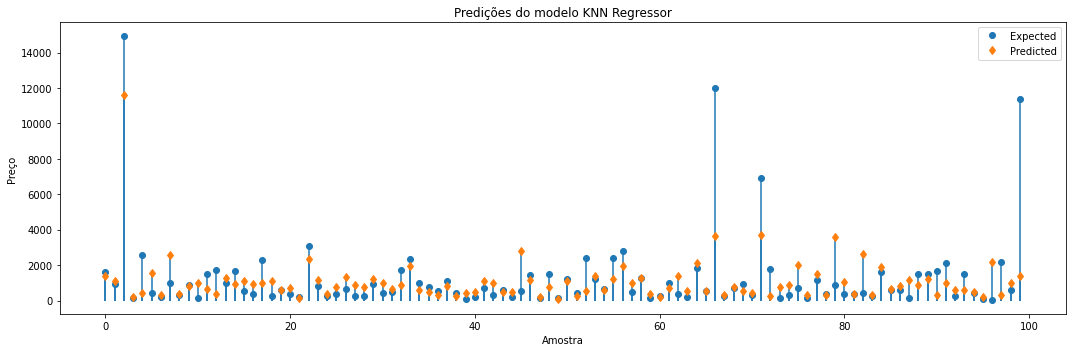

In [50]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.stem(
    range(100), y_test[:100], 
    markerfmt='C0o',
    basefmt=' ',
    label='Expected'
)

ax.stem(
    range(100), classifiers[1][1].predict(x_test[:100]), 
    # linefmt='C1', 
    markerfmt='C1d',
    basefmt=' ',
    label='Predicted'
)

ax.set(
    title=f'Predições do modelo {classifiers[1][0]} Regressor',
    xlabel='Amostra',
    ylabel='Preço'
)

plt.legend()
plt.tight_layout()
plt.savefig('assets/price_predictions.jpg', dpi=300)
plt.show()